In [1]:
# Import Package
from utils import imageUtils
from utils import postProcessing
from utils import MultiDefectDetectionDataset
from utils import evaluation
from utils import visualization
import numpy as np
import os
from chainercv.links import FasterRCNNVGG16
from chainercv.visualizations import vis_bbox
from chainercv.utils import write_image
import chainer
import math
from chainercv import utils
%matplotlib inline
import matplotlib.pyplot as plt

#load Data
root = './data/3Types/Data3TypesYminXminYmaxXmax8'
dataset = MultiDefectDetectionDataset(data_dir=root, split='train')
dataset_test = MultiDefectDetectionDataset(data_dir=root, split='test')
bbox_label_names = ('111', 'dot','100')
# DataSet Statistics
print('total number of training images: ', len(dataset))
print('total number of test images: ', len(dataset_test))
print('type of defects: ', bbox_label_names)

total number of training images:  1200
total number of test images:  15
type of defects:  ('111', 'dot', '100')


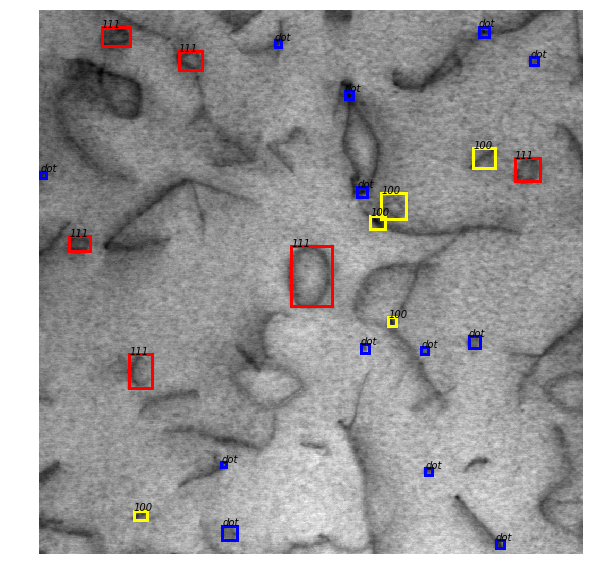

In [3]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 1, 1)
img, bbox, labels = dataset[0]
visualization.vis_bbox(img, bbox, labels, label_names=bbox_label_names, ax=ax1)
plt.show()

In [4]:
#from utils.postProcessing import img_ellipse_fitting_3kinds
from utils.imageUtils import cropImage
from skimage import exposure, morphology, measure, draw
from utils.postProcessing import img_ellipse_fitting,flood_fitting, flood_fitting_blackdot,binary_threshold_fitting_100,flood_fitting_100,binary_threshold_fitting_blackdots

def img_ellipse_fitting_3kinds(img, bboxes, labels):
    imageSize = img[0, :, :]
    subimages, bboxes = cropImage(img, bboxes)
    y_points_0 = np.array([])
    x_points_0 = np.array([])
    y_points_1 = np.array([])
    x_points_1 = np.array([])
    y_points_2 = np.array([])
    x_points_2 = np.array([])
    for subim, bbox, label in zip(subimages, bboxes, labels):
        # 111 Loops
        if label == 0:
            region1 = flood_fitting(subim)
            result = (int(region1['centroid'][0] + bbox[0]), int(region1['centroid'][1] + bbox[1]),
                      int(region1['minor_axis_length'] / 2), int(region1['major_axis_length'] / 2),
                      -region1['orientation'])
            rr, cc = draw.ellipse_perimeter(*result)
            y_points_0 = np.concatenate((y_points_0, rr))
            x_points_0 = np.concatenate((x_points_0, cc))

        # Black Dots
        if label == 1:
            region1 = flood_fitting_blackdot(subim)
            result = (int(region1['centroid'][0] + bbox[0]), int(region1['centroid'][1] + bbox[1]),
                      int(region1['minor_axis_length'] / 2), int(region1['major_axis_length'] / 2),
                      -region1['orientation'])
            rr, cc = draw.ellipse_perimeter(*result)
            y_points_1 = np.concatenate((y_points_1, rr))
            x_points_1 = np.concatenate((x_points_1, cc))
            #
            # center,phi,axes = binary_threshold_fitting_blackdots(subim)
            # rr, cc = draw.ellipse_perimeter(int(center[0]+bbox[0]),
            #                 int(center[1]+bbox[1]),
            #                 int(axes[1] ) ,
            #                 int(axes[0] ) ,
            #                 phi,
            #                 imageSize.shape)
            # y_points_1 = np.concatenate((y_points_1,rr))
            # x_points_1 = np.concatenate((x_points_1,cc))

        # 100 Loops
        if label == 2:
            # region1 = flood_fitting_100(subim)
            # result = (int(region1['centroid'][0]+bbox[0]), int(region1['centroid'][1]+bbox[1]),
            #           int(region1['minor_axis_length'] / 2), int(region1['major_axis_length'] / 2),
            #           -region1['orientation'])
            # rr,cc = draw.ellipse_perimeter(*result)
            # y_points_2 = np.concatenate((y_points_2,rr))
            # x_points_2 = np.concatenate((x_points_2,cc))

            center, phi, axes = binary_threshold_fitting_100(subim)
            if math.isnan(center[0]) or math.isnan(center[1]):
                print("X")
                continue
            if math.isnan( phi ):
                print("Y")
                continue
            if math.isnan(axes[0]) or math.isnan(axes[1]):
                print("Z")
                continue
            #print(axes)
            rr, cc = draw.ellipse_perimeter(int(center[0] + bbox[0]),
                                            int(center[1] + bbox[1]),
                                            int(axes[1]),
                                            int(axes[0]),
                                            phi,
                                            imageSize.shape)
            y_points_2 = np.concatenate((y_points_2, rr))
            x_points_2 = np.concatenate((x_points_2, cc))

    fig = plt.figure(figsize=(10, 10))
    plt.imshow(img[0, :, :], cmap='gray')
    plt.scatter(x_points_0, y_points_0, s=(1 * 72. / fig.dpi) ** 2, alpha=0.5, c='r')
    plt.scatter(x_points_1, y_points_1, s=(1 * 72. / fig.dpi) ** 2, alpha=0.5, c='b')
    plt.scatter(x_points_2, y_points_2, s=(1 * 72. / fig.dpi) ** 2, alpha=0.5, c='y')

/Users/mingrenshen/anaconda2/envs/defectDection/lib/python3.5/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/Users/mingrenshen/anaconda2/envs/defectDection/lib/python3.5/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/Users/mingrenshen/PycharmProjects/mul

(58, 59)
center =  [ 52.86256813  39.70380991]
angle of rotation =  0.767726246834
axes =  [        nan  3.25754089]
Z
(57, 57)
center =  [ 27.67620975  33.20256451]
angle of rotation =  0.244829406259
axes =  [ 22.63336843  24.5181836 ]
(168, 169)
center =  [ 82.0929336   85.04610371]
angle of rotation =  -0.553886050197
axes =  [ 70.17177158  73.08668522]
(130, 132)
center =  [ 65.97418446  69.57019516]
angle of rotation =  0.772525085806
axes =  [ 57.94280267  18.10810593]


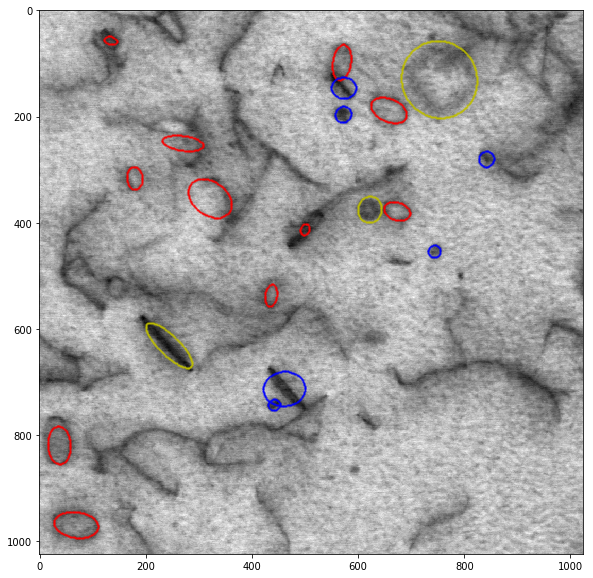

In [8]:
img_ellipse_fitting_3kinds(img,bbox,labels)
#img_ellipse_fitting(img,bbox)

In [8]:
print(label)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 1 1 1 1 1]


In [39]:
def saveImage(img,fname):
    """
    :param img (numpy.ndarray): image in CHW format
    :return: plot the red channel in grayscale color map

    """
    plt.imshow(img.transpose((1, 2, 0))[:, :, 0], cmap='gray')
    plt.axis('off')
    plt.savefig(fname,dpi=150,bbox_inches='tight')

In [40]:
def saveBWImage(img,fname):
    """
    :param img (numpy.ndarray): image in CHW format
    :return: plot the red channel in grayscale color map

    """
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.savefig(fname,dpi=150,bbox_inches='tight')

Saving Done


BW Done


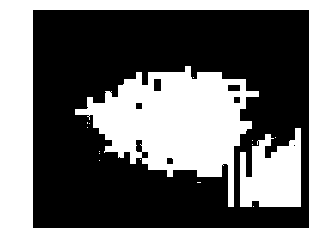

In [46]:
# save patches
from utils.imageUtils import showImage
from skimage.filters import median
from skimage.filters import threshold_minimum
from skimage import exposure, morphology, measure, draw

img, bbox, labels = dataset[1100]
subimages, bboxes = cropImage(img, bbox)

#print(type(subimages))
for i in range(len(subimages)):
    imgName = str(i)+'_'+ str(labels[i]) +".jpg"
    saveImage(subimages[i],imgName)

#showImage(subimages[20])

print("Saving Done")
# 
# read in images and BW Processing
for i in range(len(subimages)):
    imgName = str(i)+'_'+ str(labels[i]) +".jpg"
    img = io.imread(imgName)
    img.astype(np.uint8)
    #img8bits = img[:,:,0]
    img_gray = img[:,:,0]
    # plt.show(img_gray)
    # img1 = exposure.equalize_hist(img_gray)
    # invert the image
    # img2 = np.max(img_gray) - img_gray
    thresh = threshold_minimum(img_gray)
    binary = img2 > thresh
    BWimgName = str(i)+'_'+ str(labels[i])+'_BW' +".jpg"
    saveBWImage(binary,BWimgName)
    
print("BW Done")

In [8]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk

img = io.imread("0_0.jpg")

In [11]:
img.astype(np.uint8)
img.shape
img8bits = img[:,:,0]

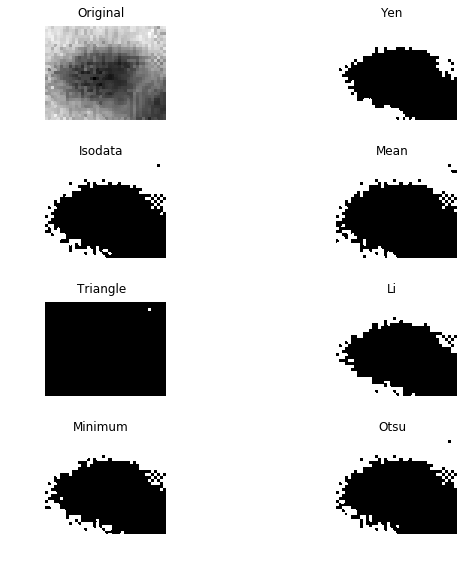

In [39]:
from skimage.filters import threshold_adaptive, threshold_otsu, threshold_yen
from skimage.filters import try_all_threshold
from skimage.filters import median

image = median(img8bits,selem = np.ones((5,5)))

fig, ax = try_all_threshold(image, figsize=(10, 8), verbose=False)
plt.show()



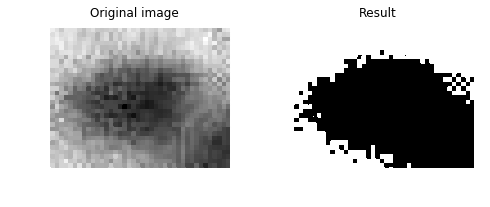

In [40]:
from skimage.filters import threshold_minimum
from skimage.filters import median

image = median(img8bits,selem = np.ones((3,3)))

thresh = threshold_minimum(image)
binary = image > thresh
#binary1 = morphology.remove_small_holes(binary, 50000, connectivity=8,in_place=True)
#print(binary1)
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(binary, cmap=plt.cm.gray)
ax[1].set_title('Result')

for a in ax:
    a.axis('off')

plt.show()


/Users/mingrenshen/anaconda2/envs/defectDection/lib/python3.5/site-packages/skimage/filters/thresholding.py:221: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
/Users/mingrenshen/anaconda2/envs/defectDection/lib/python3.5/site-packages/skimage/filters/thresholding.py:223: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '


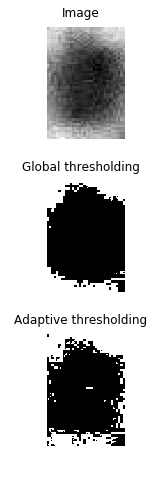

In [15]:
import matplotlib.pyplot as plt

from skimage import data
from skimage.filters import threshold_otsu, threshold_adaptive

image = img8bits

global_thresh = threshold_otsu(image)
binary_global = image > global_thresh

block_size = 501
binary_adaptive = threshold_adaptive(image, block_size, offset=10)

fig, axes = plt.subplots(nrows=3, figsize=(7, 8))
ax0, ax1, ax2 = axes
plt.gray()

ax0.imshow(image)
ax0.set_title('Image')

ax1.imshow(binary_global)
ax1.set_title('Global thresholding')

ax2.imshow(binary_adaptive)
ax2.set_title('Adaptive thresholding')

for ax in axes:
    ax.axis('off')

plt.show()

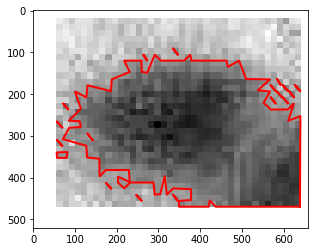

In [41]:
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon
from skimage.morphology import binary_closing
from skimage.measure import label
from skimage.morphology import remove_small_objects,closing

fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)

Xlist = list()
Ylist = list()

#binaryN = remove_small_objects(label(binary),min_size=200)



for contour in find_contours(closing(binary), 0,fully_connected='high'):
    #print(i)
    #i += 1
    #print(contour)
    for item in contour:
        Xlist.append(item[0])
        Ylist.append(item[1])
    
    coords = approximate_polygon(contour, tolerance=10)
    #print(coords)
    ax.plot(coords[:, 1], coords[:, 0], '-r', linewidth=2)
    # for item in coords:
    #     Xlist.append(item[0])
    #     Ylist.append(item[1])
    #print("Number of coordinates:", len(contour), len(coords))

#ax.axis((0, 600, 600, 0))
plt.show()



In [42]:
from numpy.linalg import eig, inv

def fitEllipse(x,y):
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    S = np.dot(D.T,D)
    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    E, V =  eig(np.dot(inv(S), C))
    n = np.argmax(np.abs(E))
    a = V[:,n]
    return a

def ellipse_center(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b-a*c
    x0=(c*d-b*f)/num
    y0=(a*f-b*d)/num
    return np.array([x0,y0])


def ellipse_angle_of_rotation( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    return 0.5*np.arctan(2*b/(a-c))


def ellipse_axis_length( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    res1=np.sqrt(up/down1)
    res2=np.sqrt(up/down2)
    return np.array([res1, res2])

def ellipse_angle_of_rotation2( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    if b == 0:
        if a > c:
            return 0
        else:
            return np.pi/2
    else:
        if a > c:
            return np.arctan(2*b/(a-c))/2
        else:
            return np.pi/2 + np.arctan(2*b/(a-c))/2
        
a = fitEllipse(np.asarray(Xlist), np.asarray(Ylist))
center = ellipse_center(a)
phi = ellipse_angle_of_rotation(a)
#phi = ellipse_angle_of_rotation2(a)
axes = ellipse_axis_length(a)

print("center = ",  center)
print("angle of rotation = ",  phi)
print("axes = ", axes)

center =  [ 291.83317912  380.99961594]
angle of rotation =  -0.16538762916
axes =  [ 169.36928536  293.17960628]


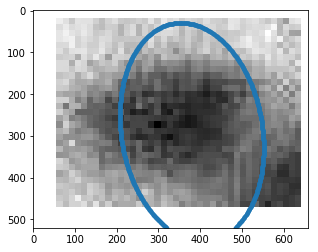

In [43]:
fig, ax = plt.subplots()
ax.imshow(img8bits, cmap=plt.cm.gray)

rr, cc = draw.ellipse_perimeter(int(center[0]), 
                                int(center[1]),
                                int(axes[1]*0.9),
                                int(axes[0]), 
                                phi, 
                                img8bits.shape)

plt.plot(cc, rr, '.')

plt.show()

In [44]:
'''

The End

'''

'\n\nThe End\n\n'

NameError: name 'center' is not defined

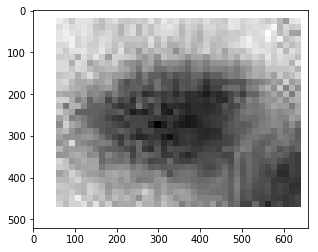

In [19]:
fig, ax = plt.subplots()
ax.imshow(img8bits, cmap=plt.cm.gray)

rr, cc = draw.ellipse_perimeter(int(center[0]), 
                                int(center[1]),
                                int(axes[1]*0.9),
                                int(axes[0]), 
                                -phi, 
                                img8bits.shape)

plt.plot(cc, rr, '.')

plt.show()

In [42]:
print(label(binary))

[[1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


In [65]:
grey_img = cv.imread('0_0_.png', cv.IMREAD_GRAYSCALE)

In [16]:
img[250,250]

0.16862745098039217

In [66]:
grey_img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ..., 
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [67]:
(im2, contours, hierarchy) = cv.findContours(grey_img, cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)

In [68]:
im2

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ..., 
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [69]:
print(contours)

[array([[[  0,   0]],

       [[  0, 599]],

       [[899, 599]],

       [[899,   0]]], dtype=int32)]


In [12]:
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

In [12]:
from skimage import io
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk

nn = io.imread("20_2.jpg", as_gray=True)
from skimage.filters import sobel
elevation_map = sobel(nn)
#sk = skeletonize(horse)
#plot_comparison(horse, sk, 'skeletonize')

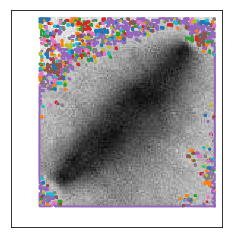

In [14]:
from skimage import measure
contours = measure.find_contours(nn,0.8)
#print(contours)
# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(nn, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

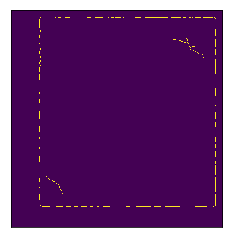

In [16]:
from skimage import io
from skimage import feature
img100 = io.imread("20_2.jpg", as_gray=True)
edges2 = feature.canny(img100, sigma=3)
# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(edges2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [20]:
import matplotlib.pyplot as plt

from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

# Load picture, convert to grayscale and detect edges
from skimage import io
from skimage import feature

image_gray = io.imread("20_2.jpg", as_gray=True)
#image_rgb = data.coffee()[0:220, 160:420]
#image_gray= color.rgb2gray(image_rgb)
edges = canny(image_gray, sigma=2.0,low_threshold=0.55, high_threshold=0.8)

# Perform a Hough Transform
# The accuracy corresponds to the bin size of a major axis.
# The value is chosen in order to get a single high accumulator.
# The threshold eliminates low accumulators
result = hough_ellipse(edges, accuracy=20, threshold=250,min_size=10, max_size=120)
print(result)
result.sort(order='accumulator')

# Estimated parameters for the ellipse
best = list(result[-1])
yc, xc, a, b = [int(round(x)) for x in best[1:5]]
orientation = best[5]

# Draw the ellipse on the original image
cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
image_gray[cy, cx] = (0, 0, 255)
# Draw the edge (white) and the resulting ellipse (red)
edges = color.gray2rgb(img_as_ubyte(edges))
edges[cy, cx] = (250, 0, 0)

fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4),sharex=True, sharey=True)

ax1.set_title('Original picture')
ax1.imshow(image_gray)

ax2.set_title('Edge (white) and result (red)')
ax2.imshow(edges)

plt.show()

[]


ValueError: Cannot specify order when the array has no fields.

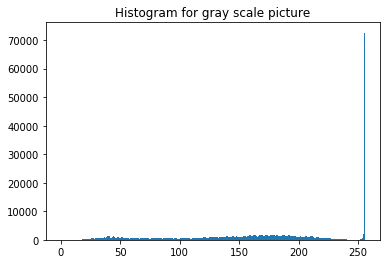

In [58]:
gray_img = cv2.imread('20_2.jpg', cv2.IMREAD_GRAYSCALE)
cv2.imshow('GoldenGate',gray_img)
hist = cv2.calcHist([gray_img],[0],None,[256],[0,256])
plt.hist(gray_img.ravel(),256,[0,256])
plt.title('Histogram for gray scale picture')
plt.show()

In [48]:
# read and downscale image
import cv2 as cv2
img = io.imread("20_2.jpg", as_gray=True)
#img = nn#cv2.pyrDown(cv2.imread('hammer.jpg', cv2.IMREAD_UNCHANGED))
img = cv2.cvtColor(img.transpose((1, 2, 0))[:, :, 0], cv2.COLOR_BGR2GRAY);
# threshold image
# this step is neccessary when you work with contours

ret, threshed_img = cv2.threshold(img, 128, 255, 0)
cv2.imshow('threshold',threshed_img)
# find contours in image
image, contours, hier = cv2.findContours(threshed_img, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
 
for cnt in contours:
    # calculate epsilon base on contour's perimeter
    # contour's perimeter is returned by cv2.arcLength
    epsilon = 0.01 * cv2.arcLength(cnt, True)
    # get approx polygons
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    # draw approx polygons
    cv2.drawContours(img, [approx], -1, (0, 255, 0), 1)
 
    # hull is convex shape as a polygon
    hull = cv2.convexHull(cnt)
    cv2.drawContours(img, [hull], -1, (0, 0, 255))
 
cv2.imshow('contours', img)

ValueError: axes don't match array

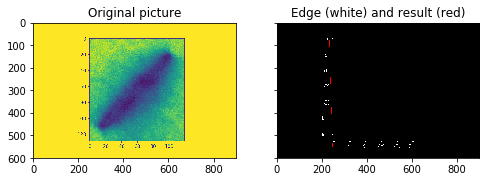

In [24]:
import matplotlib.pyplot as plt

from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

# Load picture, convert to grayscale and detect edges
#image_rgb = data.coffee()[0:220, 160:420]
image_gray = io.imread("20_2_.png", as_gray=True)

edges = canny(image_gray, sigma=2.0,
              low_threshold=0.55, high_threshold=0.8)

# Perform a Hough Transform
# The accuracy corresponds to the bin size of a major axis.
# The value is chosen in order to get a single high accumulator.
# The threshold eliminates low accumulators
result = hough_ellipse(edges, accuracy=20, threshold=150,
                       min_size=10, max_size=120)
result.sort(order='accumulator')

# Estimated parameters for the ellipse
best = list(result[-1])
yc, xc, a, b = [int(round(x)) for x in best[1:5]]
orientation = best[5]

# Draw the ellipse on the original image
cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
#image_gray[cy, cx] = (0, 0, 255)
# Draw the edge (white) and the resulting ellipse (red)
edges = color.gray2rgb(img_as_ubyte(edges))
edges[cy, cx] = (250, 0, 0)

fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4),
                                sharex=True, sharey=True)

ax1.set_title('Original picture')
ax1.imshow(image_gray)

ax2.set_title('Edge (white) and result (red)')
ax2.imshow(edges)

plt.show()

In [30]:

print(nn.dtype)

float64


In [26]:
import cv2
import numpy as np 
 
ESC = 27
 
# create a black image with size 200x200 (in grayscale)
img = np.zeros((200, 200), dtype=np.uint8)
# set the center of image to be a 50x50 white rectangle
img[50:150, 50:150] = 255
 
# threshold the image
# if any pixels that have value higher than 127, assign it to 255
ret, threshed_img = cv2.threshold(img, 127, 255, 0)
 
# find contour in image
# cv2.RETR_TREE retrieves the entire hierarchy of contours in image
# if you only want to retrieve the most external contour
# use cv.RETR_EXTERNAL
image, contours, hierarchy = cv2.findContours(threshed_img, cv2.RETR_TREE,
                            cv2.CHAIN_APPROX_SIMPLE)
# convert image back to BGR
color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
# draw contours onto image
img = cv2.drawContours(color_img, contours, -1, (0, 255, 0), 2)
 
cv2.imshow("contours", img)
 
while True:
    keycode = cv2.waitKey()
    if keycode != -1:
        keycode = 0xFF
        if keycode == ESC:
            break
 
cv2.distroyAllWindows


In [2]:
import cv2
import numpy as np 
 
# read and scale down image
img = cv2.pyrDown(cv2.imread('20_2_.png', cv2.IMREAD_UNCHANGED))
 
# threshold image
ret, threshed_img = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),127, 255, cv2.THRESH_BINARY)
# find contours and get the external one
image, contours, hier = cv2.findContours(threshed_img, cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE)
 
cv2.drawContours(img, contours, -1, (255, 255, 0), 1)
 
cv2.imshow("contours", img)
 
ESC = 27
while True:
    keycode = cv2.waitKey()
    if keycode != -1:
        keycode = 0xFF
        if keycode == ESC:
            break
cv2.destroyAllWindows()

In [ ]:
from skimage.measure import label,regionprops
import math
from skimage import draw

regions = regionprops(label(binary))

results = sorted(regions, key=lambda k: k['area'],reverse=True)
region1 = results[0]

fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)

if region1 is not None:
    props = region1
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.major_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.major_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.minor_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)
    
    rr, cc = draw.ellipse_perimeter( int(region1['centroid'][0]), 
                                     int(region1['centroid'][1]),
                                     int(region1['minor_axis_length'] / 2),
                                     int(region1['major_axis_length'] / 2), 
                                     region1['orientation'], 
                                     None)
    plt.plot(cc, rr, '.')

    #minr, minc, maxr, maxc = props.bbox
    #bx = (minc, maxc, maxc, minc, minc)
    #by = (minr, minr, maxr, maxr, minr)
    #ax.plot(bx, by, '-b', linewidth=2.5)

ax.axis((0, 600, 600, 0))
plt.show()

In [15]:
import os
os.getcwd()

'/Users/mingrenshen/PycharmProjects/multitype-defect-detection'